## 93.67% accuracy on Fashion-MNIST using Keras and Tensorflow

In this project, I created Convolutional Neural Network to achieve high accuracy in [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). The goal was to get above 90%.

Importing all the dependancies

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import helper

# Keras dependancies
import keras
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
model_path = 'models/'

import os
if not os.path.exists(model_path):
    os.makedirs(model_path)

### Importing Fashion-MNIST dataset:

In [3]:
import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("MNIST shapes")
print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_test  :", x_test.shape)
print("y_test  :", y_test.shape)

MNIST shapes
x_train : (60000, 28, 28)
y_train : (60000,)
x_test  : (10000, 28, 28)
y_test  : (10000,)


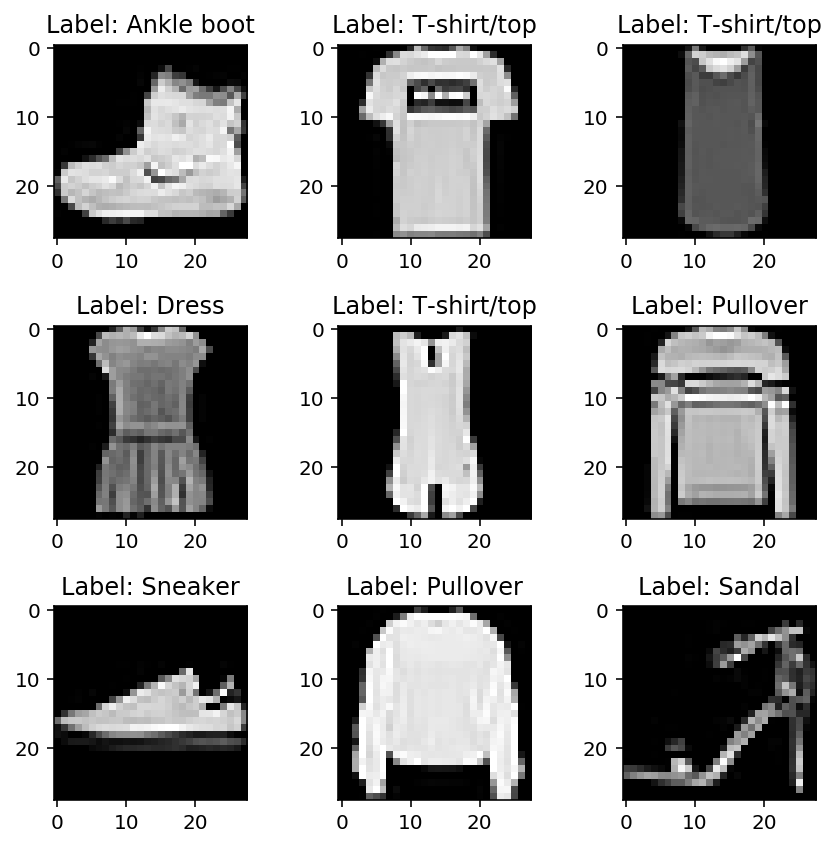

In [4]:
helper.display_nine_examples(x_train, y_train)

In [5]:
# preserving old shape
y_val_train = y_train
y_val_test = y_test
# reshaping for TensorFlow - 1 dimension for greyscale, 3 for RGB
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
print("x_train :", x_train.shape)
print("x_test  :", x_test.shape)  

x_train : (60000, 28, 28, 1)
x_test  : (10000, 28, 28, 1)


In [6]:
# Before one-hot
y_train[0:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

### [One-hot encoding](https://en.wikipedia.org/wiki/One-hot) the dataset:

In [7]:
# One-hot encoding labels for the softmax output layer
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
# After one-hot
y_train[0:10]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [9]:
# Input normalization
mean = x_train.mean().astype(np.float32)
std_dev = x_train.std().astype(np.float32)

def normalize_input(x): 
    return (x - mean) / std_dev

### Simple linear model using for testing (orders of magnitude faster than the final model):

In [10]:
def get_linear_model():
    model = Sequential()
    model.add(Lambda(normalize_input, input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.compile(Adam(), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

### Actual CNN:

Model Structure:

- 28x28x1 (Greyscale pictures) input, normalised

- Two [convolutional layers](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/), 32 neurons, Kernel size 3x3 and 3x3, [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) activation

- [Max pooling](https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks) (2 by 2)

- Two convolutional layers, 64 neurons, Kernel size 3 by 3, ReLU activation

- Another max pooling (2 by 2)

- [Flattening](https://www.quora.com/What-is-the-meaning-of-flattening-step-in-a-convolutional-neural-network) layer

- Fully connected layer, 512 neurons, ReLU activation

- Dropout 50%

- Final fully connected layer, 10 output neurons, [Softmax](https://en.wikipedia.org/wiki/Softmax_function) activation

- The network uses [Adam](https://arxiv.org/abs/1412.6980) optimizer

In [11]:
def get_model():
    model = Sequential()
    model.add(Lambda(normalize_input, input_shape=(28,28,1)))
    model.add(Conv2D(32,(3,3), activation='relu'))
    model.add(Conv2D(32,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [12]:
model = get_model()
# model = get_linear_model() # simple model used for testing

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [14]:
# Data augmentation to prevent overfitting. I'm doing here less DA than mnist
gen = image.ImageDataGenerator(rotation_range=5,
                               width_shift_range=0.05, 
                               shear_range=0.05,
                               height_shift_range=0.05, 
                               zoom_range=0.05)

### Visualising data augmentation:

/usr/local/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (9, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


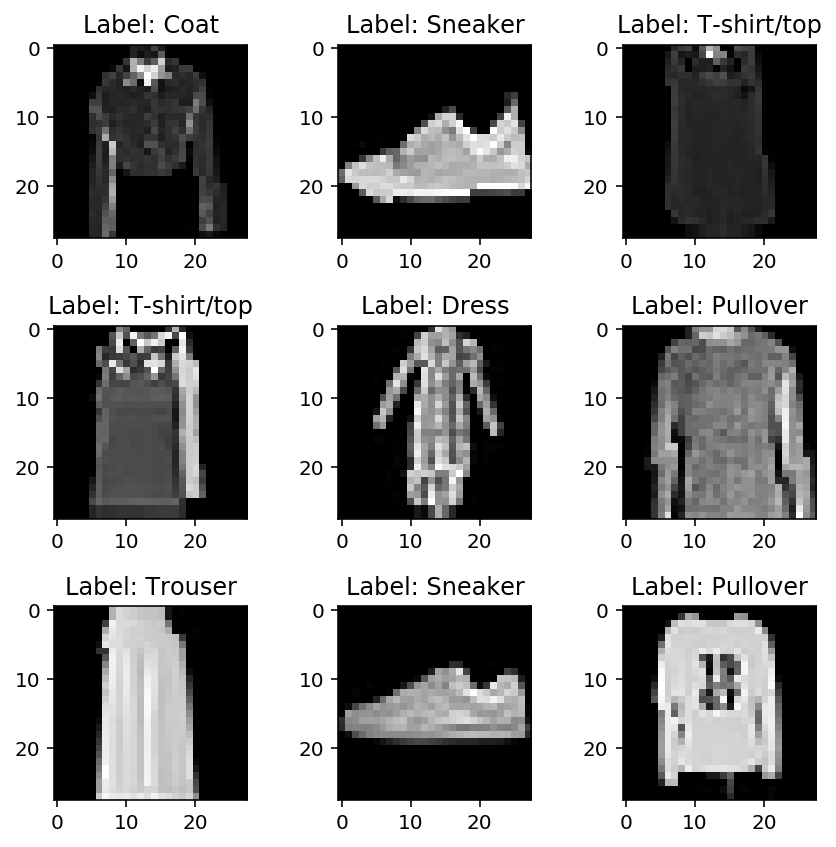

In [15]:
helper.display_data_augmentation(gen, x_test, y_val_test)

In [16]:
batch_size = 128
batches = gen.flow(x_train, y_train, batch_size)
test_batches = gen.flow(x_test, y_test, batch_size)
steps_per_epoch = batches.n // batch_size
validation_steps = test_batches.n // batch_size

In [17]:
global_history = model.fit_generator(batches,
                                     steps_per_epoch=steps_per_epoch,
                                     epochs=1,
                                     validation_data=test_batches,
                                     validation_steps=validation_steps,
                                     verbose=1)

Epoch 1/1
468/468 [==============================] - 14s - loss: 0.5971 - acc: 0.7772 - val_loss: 0.4134 - val_acc: 0.8454


In [18]:
model.save_weights(model_path+'mnist_epoch1.h5')

In [19]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=9,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/9
468/468 [==============================] - 13s - loss: 0.3836 - acc: 0.8582 - val_loss: 0.3661 - val_acc: 0.8628
Epoch 2/9
468/468 [==============================] - 13s - loss: 0.3338 - acc: 0.8777 - val_loss: 0.3166 - val_acc: 0.8843
Epoch 3/9
468/468 [==============================] - 13s - loss: 0.3070 - acc: 0.8872 - val_loss: 0.2897 - val_acc: 0.8928
Epoch 4/9
468/468 [==============================] - 13s - loss: 0.2894 - acc: 0.8930 - val_loss: 0.2750 - val_acc: 0.8990
Epoch 5/9
468/468 [==============================] - 13s - loss: 0.2717 - acc: 0.8991 - val_loss: 0.2779 - val_acc: 0.8969
Epoch 6/9
468/468 [==============================] - 13s - loss: 0.2645 - acc: 0.9030 - val_loss: 0.2629 - val_acc: 0.9002
Epoch 7/9
468/468 [==============================] - 13s - loss: 0.2519 - acc: 0.9062 - val_loss: 0.2635 - val_acc: 0.9025
Epoch 8/9
468/468 [==============================] - 13s - loss: 0.2447 - acc: 0.9100 - val_loss: 0.2547 - val_acc: 0.9045
Epoch 9/9
468/46

In [20]:
model.save_weights(model_path+'mnist_epoch10.h5')

In [21]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/10
468/468 [==============================] - 13s - loss: 0.2287 - acc: 0.9156 - val_loss: 0.2524 - val_acc: 0.9091
Epoch 2/10
468/468 [==============================] - 13s - loss: 0.2243 - acc: 0.9168 - val_loss: 0.2578 - val_acc: 0.9049
Epoch 3/10
468/468 [==============================] - 13s - loss: 0.2209 - acc: 0.9182 - val_loss: 0.2429 - val_acc: 0.9131
Epoch 4/10
468/468 [==============================] - 13s - loss: 0.2150 - acc: 0.9202 - val_loss: 0.2383 - val_acc: 0.9129
Epoch 5/10
468/468 [==============================] - 13s - loss: 0.2102 - acc: 0.9217 - val_loss: 0.2391 - val_acc: 0.9146
Epoch 6/10
468/468 [==============================] - 13s - loss: 0.2061 - acc: 0.9245 - val_loss: 0.2505 - val_acc: 0.9094
Epoch 7/10
468/468 [==============================] - 13s - loss: 0.2026 - acc: 0.9242 - val_loss: 0.2380 - val_acc: 0.9142
Epoch 8/10
468/468 [==============================] - 13s - loss: 0.2000 - acc: 0.9254 - val_loss: 0.2380 - val_acc: 0.9175
Epoch 9/

In [22]:
model.save_weights(model_path+'mnist_epoch20.h5')

In [23]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/10
468/468 [==============================] - 13s - loss: 0.1937 - acc: 0.9283 - val_loss: 0.2450 - val_acc: 0.9131
Epoch 2/10
468/468 [==============================] - 13s - loss: 0.1840 - acc: 0.9314 - val_loss: 0.2386 - val_acc: 0.9160
Epoch 3/10
468/468 [==============================] - 13s - loss: 0.1847 - acc: 0.9314 - val_loss: 0.2251 - val_acc: 0.9233
Epoch 4/10
468/468 [==============================] - 13s - loss: 0.1807 - acc: 0.9337 - val_loss: 0.2293 - val_acc: 0.9184
Epoch 5/10
468/468 [==============================] - 13s - loss: 0.1810 - acc: 0.9329 - val_loss: 0.2253 - val_acc: 0.9176
Epoch 6/10
468/468 [==============================] - 13s - loss: 0.1798 - acc: 0.9321 - val_loss: 0.2406 - val_acc: 0.9158
Epoch 7/10
468/468 [==============================] - 13s - loss: 0.1710 - acc: 0.9364 - val_loss: 0.2513 - val_acc: 0.9170
Epoch 8/10
468/468 [==============================] - 13s - loss: 0.1738 - acc: 0.9344 - val_loss: 0.2353 - val_acc: 0.9159
Epoch 9/

In [24]:
model.save_weights(model_path+'mnist_epoch30.h5')

In [25]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/10
468/468 [==============================] - 13s - loss: 0.1666 - acc: 0.9378 - val_loss: 0.2387 - val_acc: 0.9161
Epoch 2/10
468/468 [==============================] - 13s - loss: 0.1629 - acc: 0.9393 - val_loss: 0.2411 - val_acc: 0.9215
Epoch 3/10
468/468 [==============================] - 13s - loss: 0.1615 - acc: 0.9393 - val_loss: 0.2333 - val_acc: 0.9182
Epoch 4/10
468/468 [==============================] - 13s - loss: 0.1621 - acc: 0.9400 - val_loss: 0.2292 - val_acc: 0.9237
Epoch 5/10
468/468 [==============================] - 13s - loss: 0.1594 - acc: 0.9403 - val_loss: 0.2316 - val_acc: 0.9217
Epoch 6/10
468/468 [==============================] - 13s - loss: 0.1605 - acc: 0.9404 - val_loss: 0.2373 - val_acc: 0.9197
Epoch 7/10
468/468 [==============================] - 13s - loss: 0.1560 - acc: 0.9414 - val_loss: 0.2418 - val_acc: 0.9187
Epoch 8/10
468/468 [==============================] - 13s - loss: 0.1530 - acc: 0.9435 - val_loss: 0.2368 - val_acc: 0.9217
Epoch 9/

In [26]:
model.save_weights(model_path+'mnist_epoch40.h5')

In [27]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/10
468/468 [==============================] - 13s - loss: 0.1552 - acc: 0.9426 - val_loss: 0.2407 - val_acc: 0.9227
Epoch 2/10
468/468 [==============================] - 13s - loss: 0.1495 - acc: 0.9440 - val_loss: 0.2377 - val_acc: 0.9212
Epoch 3/10
468/468 [==============================] - 13s - loss: 0.1501 - acc: 0.9455 - val_loss: 0.2282 - val_acc: 0.9236
Epoch 4/10
468/468 [==============================] - 13s - loss: 0.1498 - acc: 0.9438 - val_loss: 0.2420 - val_acc: 0.9209
Epoch 5/10
468/468 [==============================] - 13s - loss: 0.1510 - acc: 0.9434 - val_loss: 0.2631 - val_acc: 0.9164
Epoch 6/10
468/468 [==============================] - 13s - loss: 0.1455 - acc: 0.9452 - val_loss: 0.2273 - val_acc: 0.9204
Epoch 7/10
468/468 [==============================] - 13s - loss: 0.1456 - acc: 0.9449 - val_loss: 0.2382 - val_acc: 0.9251
Epoch 8/10
468/468 [==============================] - 13s - loss: 0.1451 - acc: 0.9459 - val_loss: 0.2410 - val_acc: 0.9222
Epoch 9/

In [28]:
model.save_weights(model_path+'mnist_epoch50.h5')

### Testing accuracy on test dataset:

In [29]:
score = model.evaluate(x_test, y_test, verbose=1)
print("\n")
print("Accuracy :", score[1])
print("Loss     :", score[0])

 9536/10000 [===========================>..] - ETA: 0s

Accuracy : 0.9367
Loss     : 0.203899684673


### Displaying number of correct and incorrect predictions:

In [30]:
predicted_labels = model.predict_classes(x_test)

correct = np.nonzero(predicted_labels == y_val_test)[0]
incorrect = np.nonzero(predicted_labels != y_val_test)[0]
print("\n")
print(" Number of correct predictions   : {}/{}".format(len(correct), len(predicted_labels)))
print(" Number of incorrect predictions : {}/{}".format(len(incorrect), len(predicted_labels)))

 9920/10000 [============================>.] - ETA: 0s

 Number of correct predictions   : 9367/10000
 Number of incorrect predictions : 633/10000


### Random correct predictions:

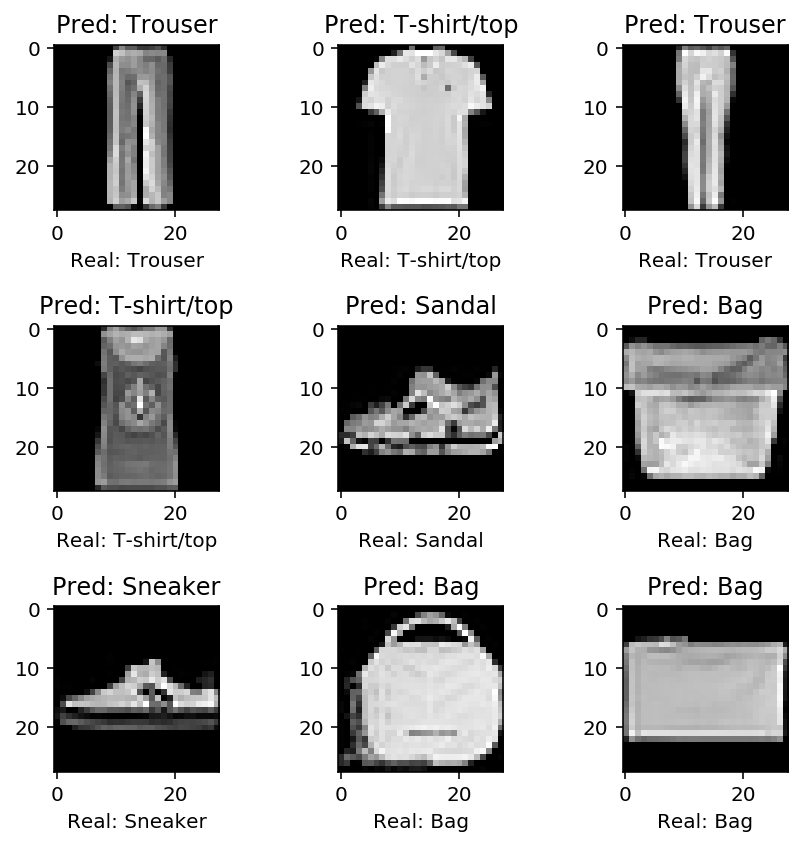

In [31]:
helper.display_nine_random_predictions(predicted_labels, correct, x_test, y_val_test)

### Random incorrect predictions

In my opinion, this shows the issue with Fashion-MNIST dataset. The items in different categories are often very similar to each other and the labels are arbitrary (see first two items in 2 and 3rd rows of the example):

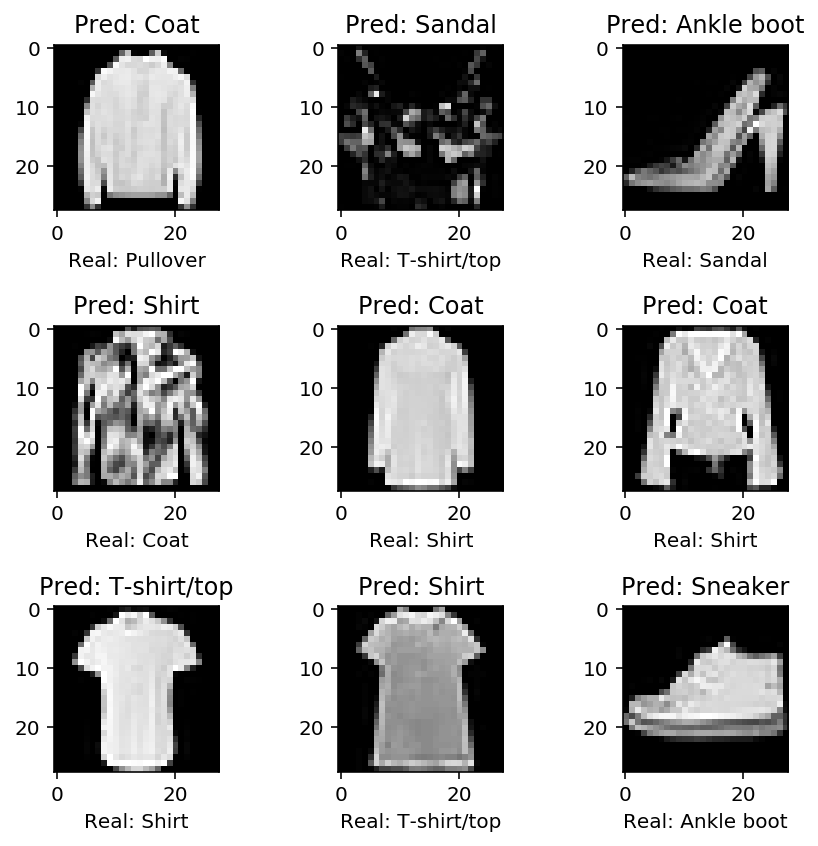

In [32]:
helper.display_nine_random_predictions(predicted_labels, incorrect, x_test, y_val_test)

### Training stats:

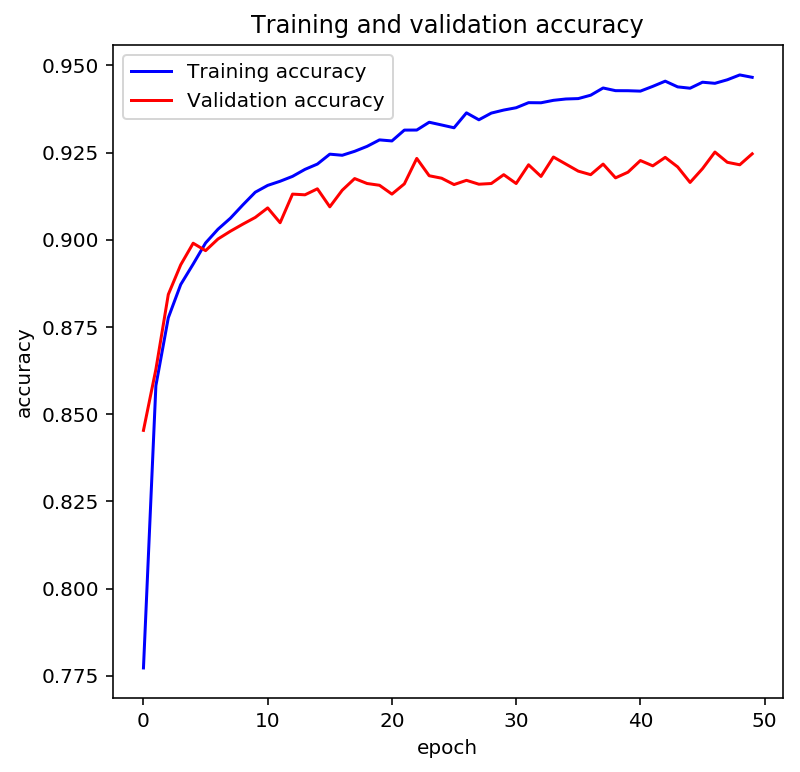

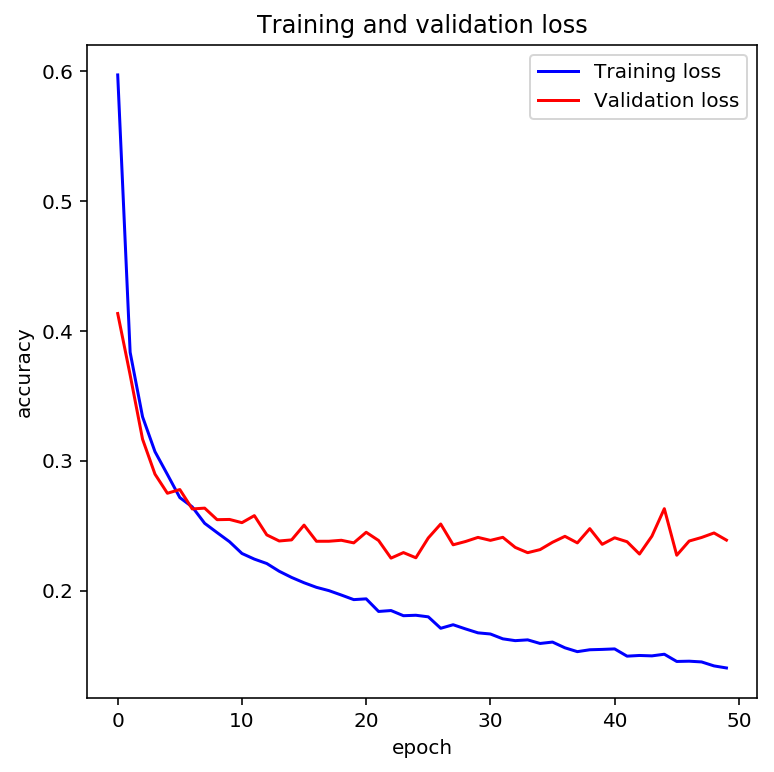

In [33]:
helper.display_accuracy_and_loss(global_history)

### Displaying 4 random wrong predictions with probabilities

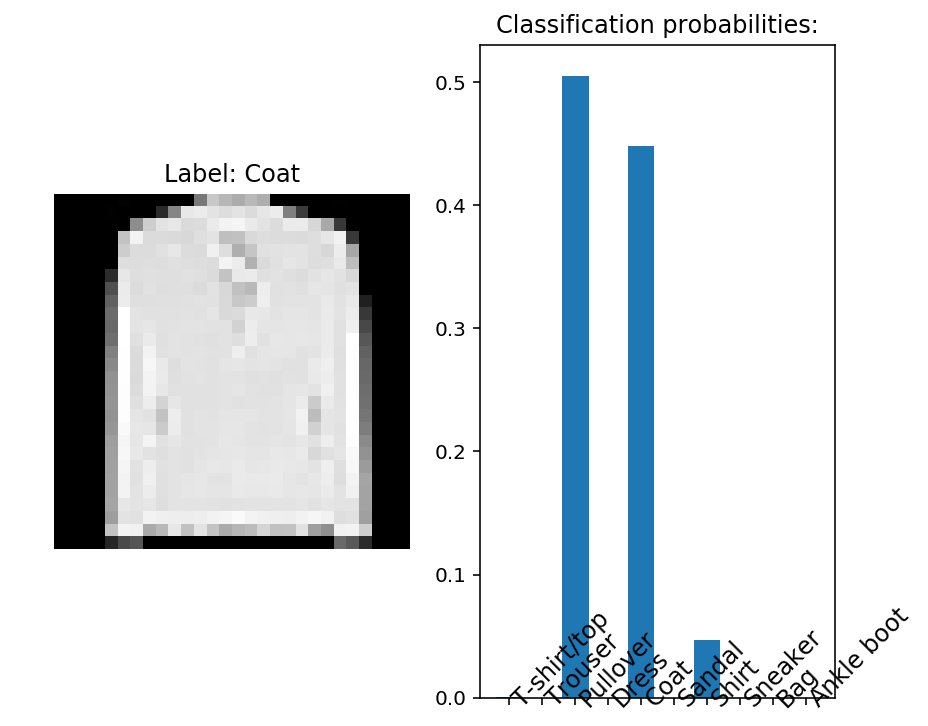

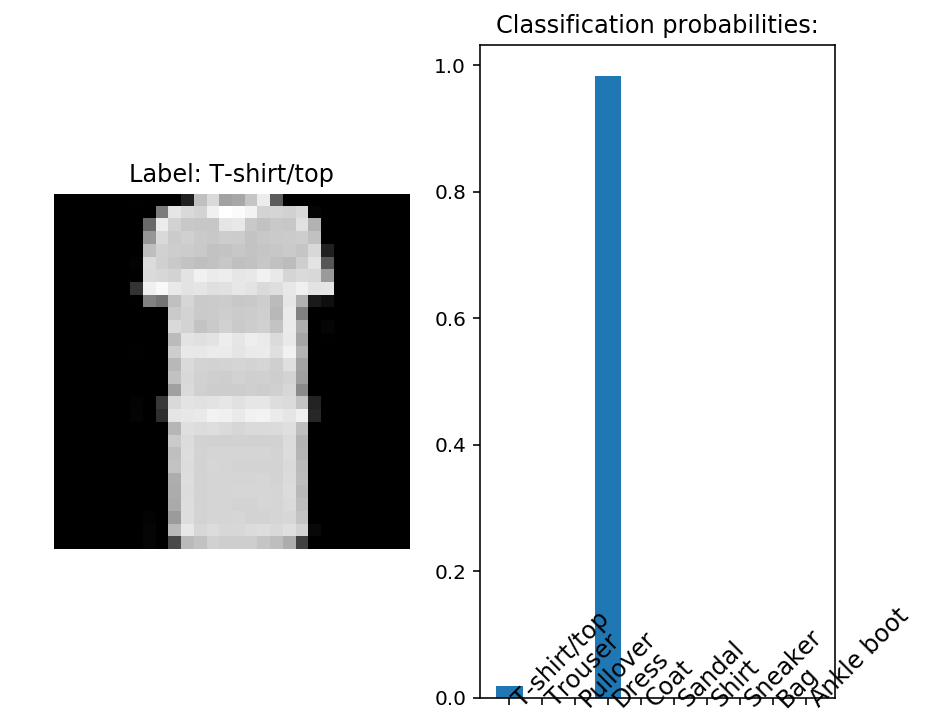

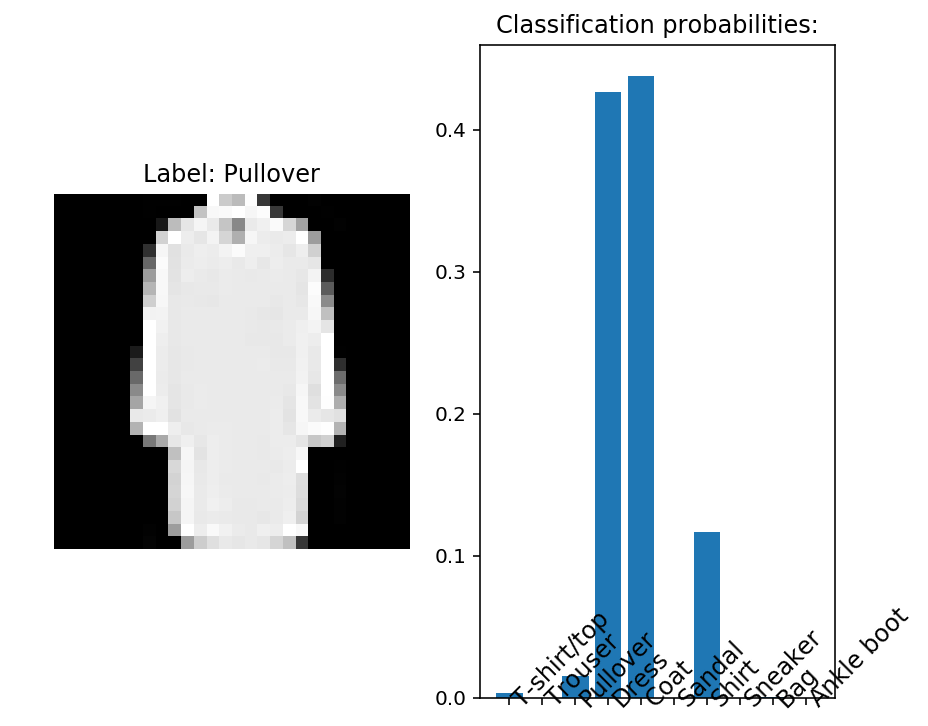

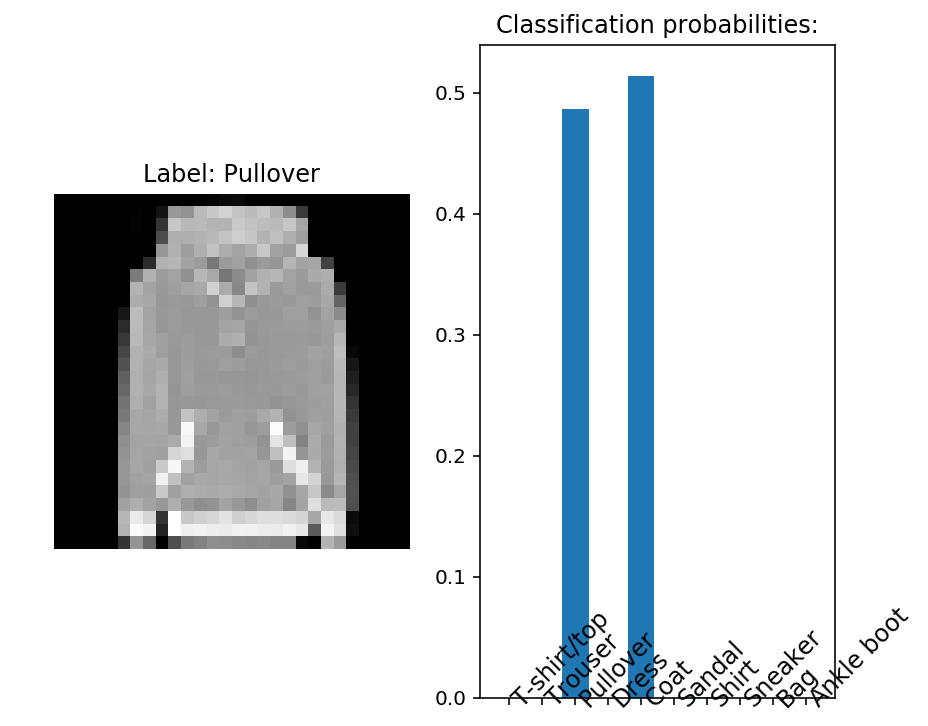

In [34]:
helper.display_incorect_with_probabilities(model, incorrect, x_test, y_val_test, 4)